In [1]:
import torch
import numpy as np
from scipy.special import binom, factorial
import matplotlib.pyplot as plt

from tactis.tactis.model.tactis import TACTiS
from tactis.tactis.model.decoder import CopulaDecoder, AttentionalCopula
from tactis.tactis.model.marginal import DSFMarginal

# TODO
1. Create datasets (IID uniform(0,1) & normals)
1. Create functions for copulas
1. Initialize TACTiS model
1. Train model
1. Use closed form expressions to check if what copula is doing

## Datasets & Closed-Form Expressions

### IID Uniform(0,1)

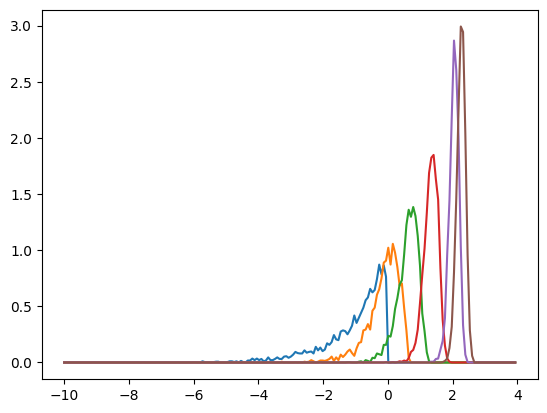

In [745]:
# Dataset
def uniform_timeseries(batch_size, length, split=0.9):
    split_n = int(split * length)

    X = torch.rand(batch_size, length).cumsum(dim=-1)
    X_train, X_test = X[:, :split_n], X[:, split_n:]

    return X_train, X_test

batch_size = 4096
lengths = [1, 2, 4, 8, 16, 20]

empirical_dists = [uniform_timeseries(batch_size, l, split=1)[0] for l in lengths]
for dist in empirical_dists:
    ys, xs = torch.histogram(torch.log(dist[:, -1]).flatten(), bins=200, density=True, range=(-10, 4))
    plt.plot(xs[:-1], ys)
plt.show()

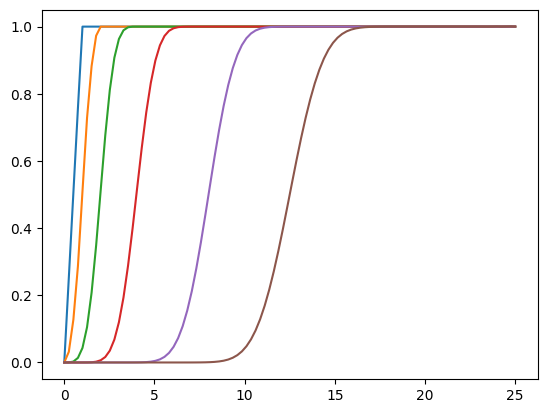

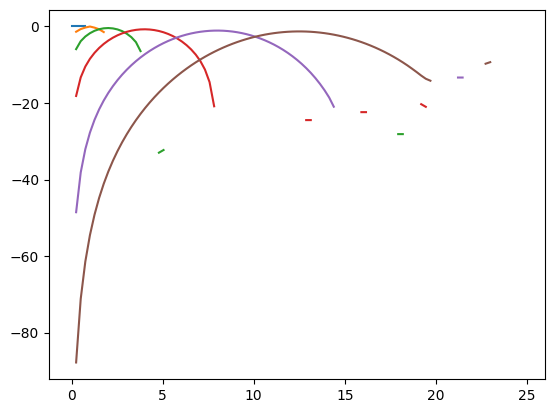

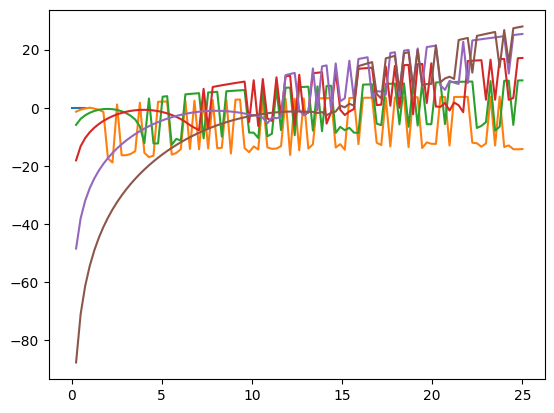

In [779]:
# Distribution functions
def irwin_hall(n, dist_fcn='cdf'):
    assert n > 0 and int(n) == n, "n must be a positive integer"
    assert dist_fcn in ['cdf', 'pdf'], "Choose either CDF or Density of distribution"
    
    ReLU = torch.nn.ReLU()
    if n == 1:
        return (lambda x : ReLU(x) - ReLU(x-1)) if dist_fcn == 'cdf' else (lambda x : np.heaviside(x, 1) - np.heaviside(x-1, 1))

    ks = torch.arange(n+1)
    coeffs = binom(n, ks) * (-1) ** ks 
    power = n if dist_fcn == 'cdf' else n - 1
    normalization = factorial(n) if dist_fcn == 'cdf' else factorial(n - 1)
    
    def _irwin_hall_n(x: float):
        return torch.inner(coeffs, ReLU(x.expand(n+1, x.shape[-1]).T - ks).double() ** power) / normalization
    
    return _irwin_hall_n

def ReLogU():
    ReLU = torch.nn.ReLU()
    return lambda x: torch.log(ReLU(x) + np.heaviside(-x, 1))

def log_ReLU():
    ReLU = torch.nn.ReLU()
    return lambda x: torch.log(ReLU(x))

def _log_factorial_vect(ns):
    l = ns.shape[0]
    relogu = ReLogU()
    return relogu(ns.expand(l, l).T - ns).sum(dim=1)

def log_factorial(n):
    if isinstance(n, torch.Tensor) and n.nelement() > 1:
        return _log_factorial_vect(n)
    
    ns = torch.arange(1, n+1)
    return torch.log(ns).sum()

def _log_binomial_vect(n, ks):
    return log_factorial(n) - _log_factorial_vect(ks) - _log_factorial_vect(n - ks)

def log_binomial(n, k):
    if isinstance(k, torch.Tensor) and k.nelement() > 1:
        return _log_binomial_vect(n, k)
    
    return log_factorial(n) - log_factorial(k) - log_factorial(n-k)

def alt_logsumexp(input):
    # input.shape == (B, n)
    C = input.max(dim=-1)[0] # (B, )

    alt_ones = torch.ones_like(input)
    alt_ones[..., 1::2] *= -1

    shifted_input = input - C.unsqueeze(1)

    alt_sum = (alt_ones * torch.exp(shifted_input)).sum(dim=-1)
    return C + ReLogU()(alt_sum)

def log_irwin_hall(n, dist_fcn='cdf'):
    assert n > 0 and int(n) == n, "n must be a positive integer"
    assert dist_fcn in ['cdf', 'pdf'], "Choose either CDF or Density of distribution"

    if n == 1:
        return lambda x: torch.log(irwin_hall(n, dist_fcn)(x))

    ks = torch.arange(n+1)
    power = n if dist_fcn == 'cdf' else n - 1
    log_relu = log_ReLU()    
    log_coeffs = log_binomial(n, ks)
    log_normalization = log_factorial(n) if dist_fcn == 'cdf' else log_factorial(n - 1)
    
    def _log_irwin_hall_n(x: float):
        x = torch.tensor(x) if not isinstance(x, torch.Tensor) else x
        shifted_xs = x.expand(n+1, x.shape[-1]).T - ks

        log_irwin_hall_terms = power*log_relu(shifted_xs) + log_coeffs
        return alt_logsumexp(log_irwin_hall_terms) - log_normalization
    
    return _log_irwin_hall_n

ns = [1, 2, 4, 8, 16, 25]
xs = torch.linspace(0, ns[-1], 100)

test_cdfs = [irwin_hall(n, dist_fcn='cdf') for n in ns]
test_pdfs = [irwin_hall(n, dist_fcn='pdf') for n in ns]
test_log_pdfs = [log_irwin_hall(n, dist_fcn='pdf') for n in ns]

probs = [cdf(xs) for cdf in test_cdfs]
for p in probs:
    plt.plot(xs, p)
plt.show()

probs = [torch.log(pdf(xs)) for pdf in test_pdfs]
for p in probs:
    plt.plot(xs, p)
plt.show()

probs = [pdf(xs) for pdf in test_log_pdfs]
for p in probs:
    plt.plot(xs, p)
plt.show()



In [1008]:
n = 10
# x = n * torch.rand(1)
x = torch.tensor([9.9992])
print(f"Test Input x: {x}")

log_relu = log_ReLU()
relu = torch.nn.ReLU()
ks = torch.arange(n+1)

coeffs = binom(n, ks)
log_coeffs = log_binomial(n, ks)

power = n - 1
log_normalization = log_factorial(n - 1)
normalization = factorial(n - 1)
    

def _test_irwin_hall_n(x):
    x = torch.tensor([x]) if not isinstance(x, torch.Tensor) else x

    log_irwin_hall_terms = power*log_relu(x - ks) + log_coeffs
    return alt_logsumexp(log_irwin_hall_terms) - log_normalization

terms = (coeffs * relu(x.expand(n+1, x.shape[-1]).T - ks).double() ** power)
test_log_terms = power*log_relu(x - ks) + log_coeffs

print(f"Test log terms: {test_log_terms}")
print(f"Actual log terms: {log_relu(terms).squeeze()}")

alt_ones = torch.ones_like(terms)
alt_ones[..., 1::2] *= -1

test_log_prob = alt_logsumexp(test_log_terms)
prob = (alt_ones * terms).sum()

print('--------')
print(f"Test log probs: {test_log_prob - log_normalization}")
print(f"Actual prob: {prob / normalization}")
print(f"Actual log prob: {torch.log(prob / normalization)}")

Test Input x: tensor([9.9992])
Test log terms: tensor([20.7225, 22.0768, 22.5207, 22.2997, 21.4717, 20.0129, 17.8220, 14.6726,
        10.0414,  2.2954,    -inf], dtype=torch.float64)
Actual log terms: tensor([20.7225, 22.0768, 22.5207, 22.2997, 21.4717, 20.0129, 17.8220, 14.6726,
        10.0414,  2.2954,    -inf], dtype=torch.float64)


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [1054]:
torch.manual_seed(314)
n = 10
batch_size = 1

relu = torch.nn.ReLU()
ks = torch.arange(n+1)
coeffs = binom(n, ks)
log_coeffs = log_binomial(n, ks)
power = n - 1

xs = torch.rand(batch_size) + n - 1
terms = coeffs * relu(xs.expand(n+1, xs.shape[-1]).T - ks).double() ** power
test_terms = power * log_relu( xs.expand(n+1, xs.shape[-1]).T - ks ) + log_coeffs

errors = torch.abs(test_terms - torch.log( terms ))
errors = errors[~errors.isnan()]
xs, errors.max()

alt_ones = torch.ones_like(terms)
alt_ones[..., 1::2] *= -1

C = test_terms.max(dim=1)[0].unsqueeze(-1)
alt_sum = (alt_ones * torch.exp(test_terms - C)).sum()

# (alt_ones * torch.exp(test_terms - C)).cumsum(dim=-1), 
reversed((alt_ones * torch.exp(test_terms - C))[0]).cumsum(dim=-1), reversed((alt_ones * torch.exp(test_terms - C))[0]), (alt_ones * terms).sum()

(tensor([ 0.0000e+00, -1.1815e-10,  1.3506e-06, -2.2159e-04,  6.3118e-03,
         -6.0522e-02,  2.5349e-01, -5.1159e-01,  4.8841e-01, -1.7671e-01,
         -1.5363e-06], dtype=torch.float64),
 tensor([ 0.0000e+00, -1.1815e-10,  1.3507e-06, -2.2294e-04,  6.5334e-03,
         -6.6833e-02,  3.1402e-01, -7.6508e-01,  1.0000e+00, -6.6512e-01,
          1.7671e-01], dtype=torch.float64),
 tensor(1.0490e-05, dtype=torch.float64))

tensor([  0.0000e+00, -6.7043e-222,  9.4413e-183, -1.5758e-161,  1.1097e-146,
        -3.6804e-135,  1.0666e-125, -1.2128e-117,  1.3003e-110, -2.2953e-104,
          9.7249e-99,  -1.2919e-93,   6.5477e-89,  -1.4694e-84,   1.6385e-80,
         -9.9480e-77,   3.5403e-73,  -7.8437e-70,   1.1373e-66,  -1.1256e-63,
          7.8773e-61,  -4.0188e-58,   1.5342e-55,  -4.4829e-53,   1.0228e-50,
         -1.8541e-48,   2.7119e-46,  -3.2446e-44,   3.2141e-42,  -2.6654e-40,
          1.8685e-38,  -1.1171e-36,   5.7425e-35,  -2.5565e-33,   9.9221e-32,
         -3.3776e-30,   1.0141e-28,  -2.6990e-27,   6.3975e-26,  -1.3563e-24,
          2.5819e-23,  -4.4296e-22,   6.8722e-21,  -9.6711e-20,   1.2381e-18,
         -1.4457e-17,   1.5436e-16,  -1.5104e-15,   1.3574e-14,  -1.1225e-13,
          8.5575e-13,  -6.0247e-12,   3.9226e-11,  -2.3655e-10,   1.3229e-09,
         -6.8694e-09,   3.3158e-08,  -1.4892e-07,   6.2289e-07,  -2.4284e-06,
          8.8309e-06,  -2.9972e-05,   9.5002e-05,  -2.8133e-04, 

In [1060]:
n = 10
batch_size = 16

relu = torch.nn.ReLU()
ks = torch.arange(n+1)
coeffs = binom(n, ks)
power = n - 1
log_normalization = log_factorial(n - 1)
normalization = factorial(n - 1)

def irwin_hall_terms(x, n):
    return coeffs * relu(x.expand(n+1, x.shape[-1]).T - ks).double() ** power

xs = torch.rand(batch_size) + n - 1
terms = irwin_hall_terms(xs, n)
log_terms = torch.log(terms)

alt_ones = torch.ones_like(terms)
alt_ones[..., 1::2] *= -1

test_log_probs = alt_logsumexp(log_terms) - log_normalization
log_probs = torch.log( (alt_ones * terms).sum(dim=1) / normalization )

errors = torch.abs(test_log_probs - log_probs)
errors = errors[~errors.isnan() & ~errors.isinf()]

xs, test_log_probs, log_probs, errors.max()

(tensor([9.5520, 9.7685, 9.0097, 9.6047, 9.9831, 9.7272, 9.5653, 9.9925, 9.0778,
         9.4779, 9.5858, 9.3026, 9.2581, 9.5922, 9.8906, 9.7023]),
 tensor([-20.0329,   9.4556, -12.8894, -21.1523,   9.7008, -26.6361, -20.3038,
         -25.0796, -13.5307, -18.6504, -20.7305, -16.0453, -15.4884, -20.8559,
           9.5959, -23.6447], dtype=torch.float64),
 tensor([-20.0275, -25.9716, -12.8894, -21.1554,      nan, -24.3622, -20.3000,
             -inf, -13.5307, -18.6511, -20.7352, -16.0451, -15.4884, -20.8748,
              nan, -23.6690], dtype=torch.float64),
 tensor(35.4272, dtype=torch.float64))

In [964]:
from UniformSumDistribution import UniformSumDistribution

n = 23
distribution = UniformSumDistribution(n)
distribution.logpdf(n-1)

nan

In [ ]:
# Copula
def irwin_hall_copula(ns):
    # Mathematically, equal to ratio of uniform(0, 1) marginals & I-H(n) marginals
    def _irwin_hall_copula(hist_time, hist_value, pred_time, pred_value):
        # I-H marginals = irwin_hall(pred_time + 1)
        # Uniform
        # Naive copula

        


    return 
    

### Correlated Gaussian

#### Dataset

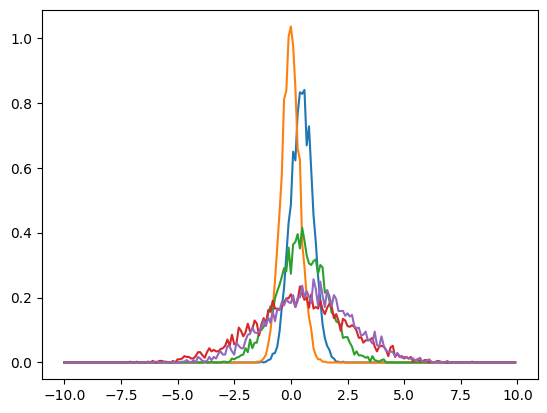

In [193]:
# Dataset
def gaussian_timeseries(batch_size, mean, cov, split=0.9):
    split_n = int(split * mean.shape[0])

    sample_shape = torch.Size([batch_size])
    multivariate_normal = torch.distributions.MultivariateNormal(loc=mean, covariance_matrix=cov)

    X = multivariate_normal.sample(sample_shape)
    X_train, X_test = X[:, :split_n], X[:, split_n:]

    return X_train, X_test

batch_size = 4096
lengths = [1, 2, 4, 8, 16]

means = [torch.rand(l) for l in lengths]
covs = [c.T @ c for c in [torch.rand(l, l) for l in lengths]]

empirical_dists = [gaussian_timeseries(batch_size, mean, cov, split=1)[0] for mean, cov in zip(means, covs)]
for dist in empirical_dists:
    ys, xs = torch.histogram(dist[:, -1].flatten(), bins=200, density=True, range=(-10, 10))
    plt.plot(xs[:-1], ys)
plt.show()

#### Distribution Functions

In [255]:
from torch.distributions import Normal, MultivariateNormal

def series_covariance_matrix(incr_covariance_matrix):
    def cov_nm(n, m):
        return sum([incr_covariance_matrix[i][j] for i in range(n+1) for j in range(m+1)])

    series_cov = torch.zeros_like(incr_covariance_matrix)
    for n in range(series_cov.shape[0]):
        for m in range(series_cov.shape[0]):
            series_cov[n, m] = cov_nm(n, m)

    return series_cov

#### Copula Function

In [259]:
def gaussian_copula(covariance_matrix):
    n = covariance_matrix.shape[0]

    prod_var_matrix = torch.outer(torch.diag(covariance_matrix), torch.diag(covariance_matrix))
    correlation_matrix = covariance_matrix / torch.sqrt(prod_var_matrix)

    mv_normal = MultivariateNormal(loc=torch.zeros(n), covariance_matrix=correlation_matrix)
    std_mv_normal = MultivariateNormal(loc=torch.zeros(n), covariance_matrix=torch.eye(n))
    std_uni_normal = Normal(loc=0, scale=1)

    def log_copula(u):
        quantiles = std_uni_normal.icdf(u)
        mv_log_probs = mv_normal.log_prob(quantiles)
        std_log_prob = torch.nan_to_num(std_mv_normal.log_prob(quantiles), nan=0.)

        return mv_log_probs - std_log_prob

    return log_copula

def sklar_log_gaussian_pdf(mean, covariance_matrix):
    marginals = [Normal(mean[i], covariance_matrix[i, i]**0.5) for i in range(mean.shape[0])]
    log_copula = gaussian_copula(covariance_matrix)
    
    def sklar_log_pdf(x):
        marginal_cdfs = torch.stack([marg.cdf(x[..., i]) for i, marg in enumerate(marginals)], dim=-1)
        marginal_log_pdfs = torch.stack([marg.log_prob(x[..., i]) for i, marg in enumerate(marginals)], dim=-1)

        return log_copula(marginal_cdfs) + marginal_log_pdfs.sum(dim=-1)

    return sklar_log_pdf

def sklar_log_gaussian_timeseries_copula(series_mean, series_covariance_matrix):
    log_sklar_copula = sklar_log_gaussian_pdf(series_mean, series_covariance_matrix)

    def _log_copula_wrapper(hist_time, hist_value, pred_time, pred_value):
        pred_cumsums = pred_value - hist_value[..., -1]
        return log_sklar_copula(pred_cumsums)
    
        pred_increments = pred_value - torch.cat([hist_value[..., -1].unsqueeze(dim=-1), pred_value[..., :-1]], dim=-1)
        pred_cumsums = pred_value - hist_value[..., -1]

        incr_log_probs = incr_joint_dist.log_prob(pred_increments)

        cumsum_log_probs = [dist_fcn.log_prob(pred_value[..., i]) for i, dist_fcn in enumerate(series_marginal_dists)]
        cumsum_log_probs = torch.stack(cumsum_log_probs, dim=-1)
        sum_cumsum_log_probs = torch.nan_to_num(cumsum_log_probs.sum(dim=-1), nan=0.)

        return incr_log_probs - sum_cumsum_log_probs
    
    return _log_copula_wrapper

# torch.manual_seed(123456)

n = 128
copula_test_mean = torch.randn(n)
copula_test_cov = torch.randn(n, n)
copula_test_cov = copula_test_cov.T @ copula_test_cov

sklar = sklar_log_gaussian_pdf(copula_test_mean, copula_test_cov)
mv_normal = MultivariateNormal(copula_test_mean, copula_test_cov)

test_input = torch.randn(8, n)

# print(f"Test input: {test_input}")
print(f"Sklar copula result: {sklar(test_input)}")
print(f"True density result: {mv_normal.log_prob(test_input)}")

Sklar copula result: tensor([-1151.7693,  -683.4053,  -838.2153,  -438.6900,  -827.0323,  -510.5612,
        -1707.0643, -1416.4685])
True density result: tensor([-1153.4446,  -683.5259,  -838.8468,  -438.8107,  -828.0221,  -510.7299,
        -1709.7948, -1418.6716])


## Model Training

## Model vs Theoretical

In [263]:
# Hyperparameters
batch_size = 100000
p = 10
train_test_split = 0.9

In [261]:
# Model Definition
device = torch.device("cuda")

def create_net():
    net = TACTiS(
        num_series=10,
        series_embedding_dim=5,
        input_encoder_layers=3,
        input_encoding_normalization=True,
        data_normalization="standardization",
        loss_normalization="series",
        positional_encoding={
            "dropout": 0.0,
        },
        temporal_encoder={
            "attention_layers": 3,
            "attention_heads": 3,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        copula_decoder={
            "min_u": 0.01,
            "max_u": 0.99,
            "attentional_copula": {
                "attention_heads": 3,
                "attention_layers": 3,
                "attention_dim": 16,
                "mlp_layers": 3,
                "mlp_dim": 16,
                "resolution": 50,
            },
            "dsf_marginal": {
                "mlp_layers": 2,
                "mlp_dim": 8,
                "flow_layers": 2,
                "flow_hid_dim": 8,
            },
        },
    )
    return net.to(device)

In [260]:
# Model Training
def step(net, optimizer, batch_size, data, hist_length, pred_length):
    max_idx = data.shape[1] - (hist_length + pred_length)
    
    hist_values = []
    pred_values = []
    for _ in range(batch_size):
        idx = np.random.randint(0, max_idx)
        hist_values.append(data[:, idx:idx+hist_length])
        pred_values.append(data[:, idx+hist_length:idx+hist_length+pred_length])
    
    # [batch, series, time steps]
    hist_value = torch.Tensor(hist_values).to(device)
    pred_value = torch.Tensor(pred_values).to(device)
    hist_time = torch.arange(0, hist_length, device=device)[None, :].expand(batch_size, -1)
    pred_time = torch.arange(hist_length, hist_length + pred_length, device=device)[None, :].expand(batch_size, -1)
    
    optimizer.zero_grad()
    loss = net.loss(hist_time, hist_value, pred_time, pred_value)
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [264]:
# Generate Dataset
torch.manual_seed(12345)

mean = torch.randn(p)
cov_matrix = torch.randn(p, p)
cov_matrix = cov_matrix.T @ cov_matrix

net = create_net()
train_data, tests_data = gaussian_timeseries(batch_size, mean, cov_matrix, train_test_split)
optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3, weight_decay=0)

AssertionError: Torch not compiled with CUDA enabled